In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 5.5 MB/s 


In [ ]:
 import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import string

# Reset the output dimensions
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import f1_score, accuracy_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset

from scipy import linalg

from collections import Counter

import pickle

import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

from gensim import matutils, models
from gensim.models import Word2Vec

import scipy.sparse

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

plt.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-darkgrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Detect hardware, return appropriate distribution strategy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS available: ", strategy.num_replicas_in_sync)

REPLICAS available:  1


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/tweet analys/train_E6oV3lV.csv')
test = pd.read_csv('/content/drive/MyDrive/tweet analys/test_tweets_anuFYb8.csv')

In [ ]:
train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['tweet'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['tweet'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['tweet'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['tweet'].apply(lambda x: len(str(x)))
test['char_count'] = test['tweet'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))

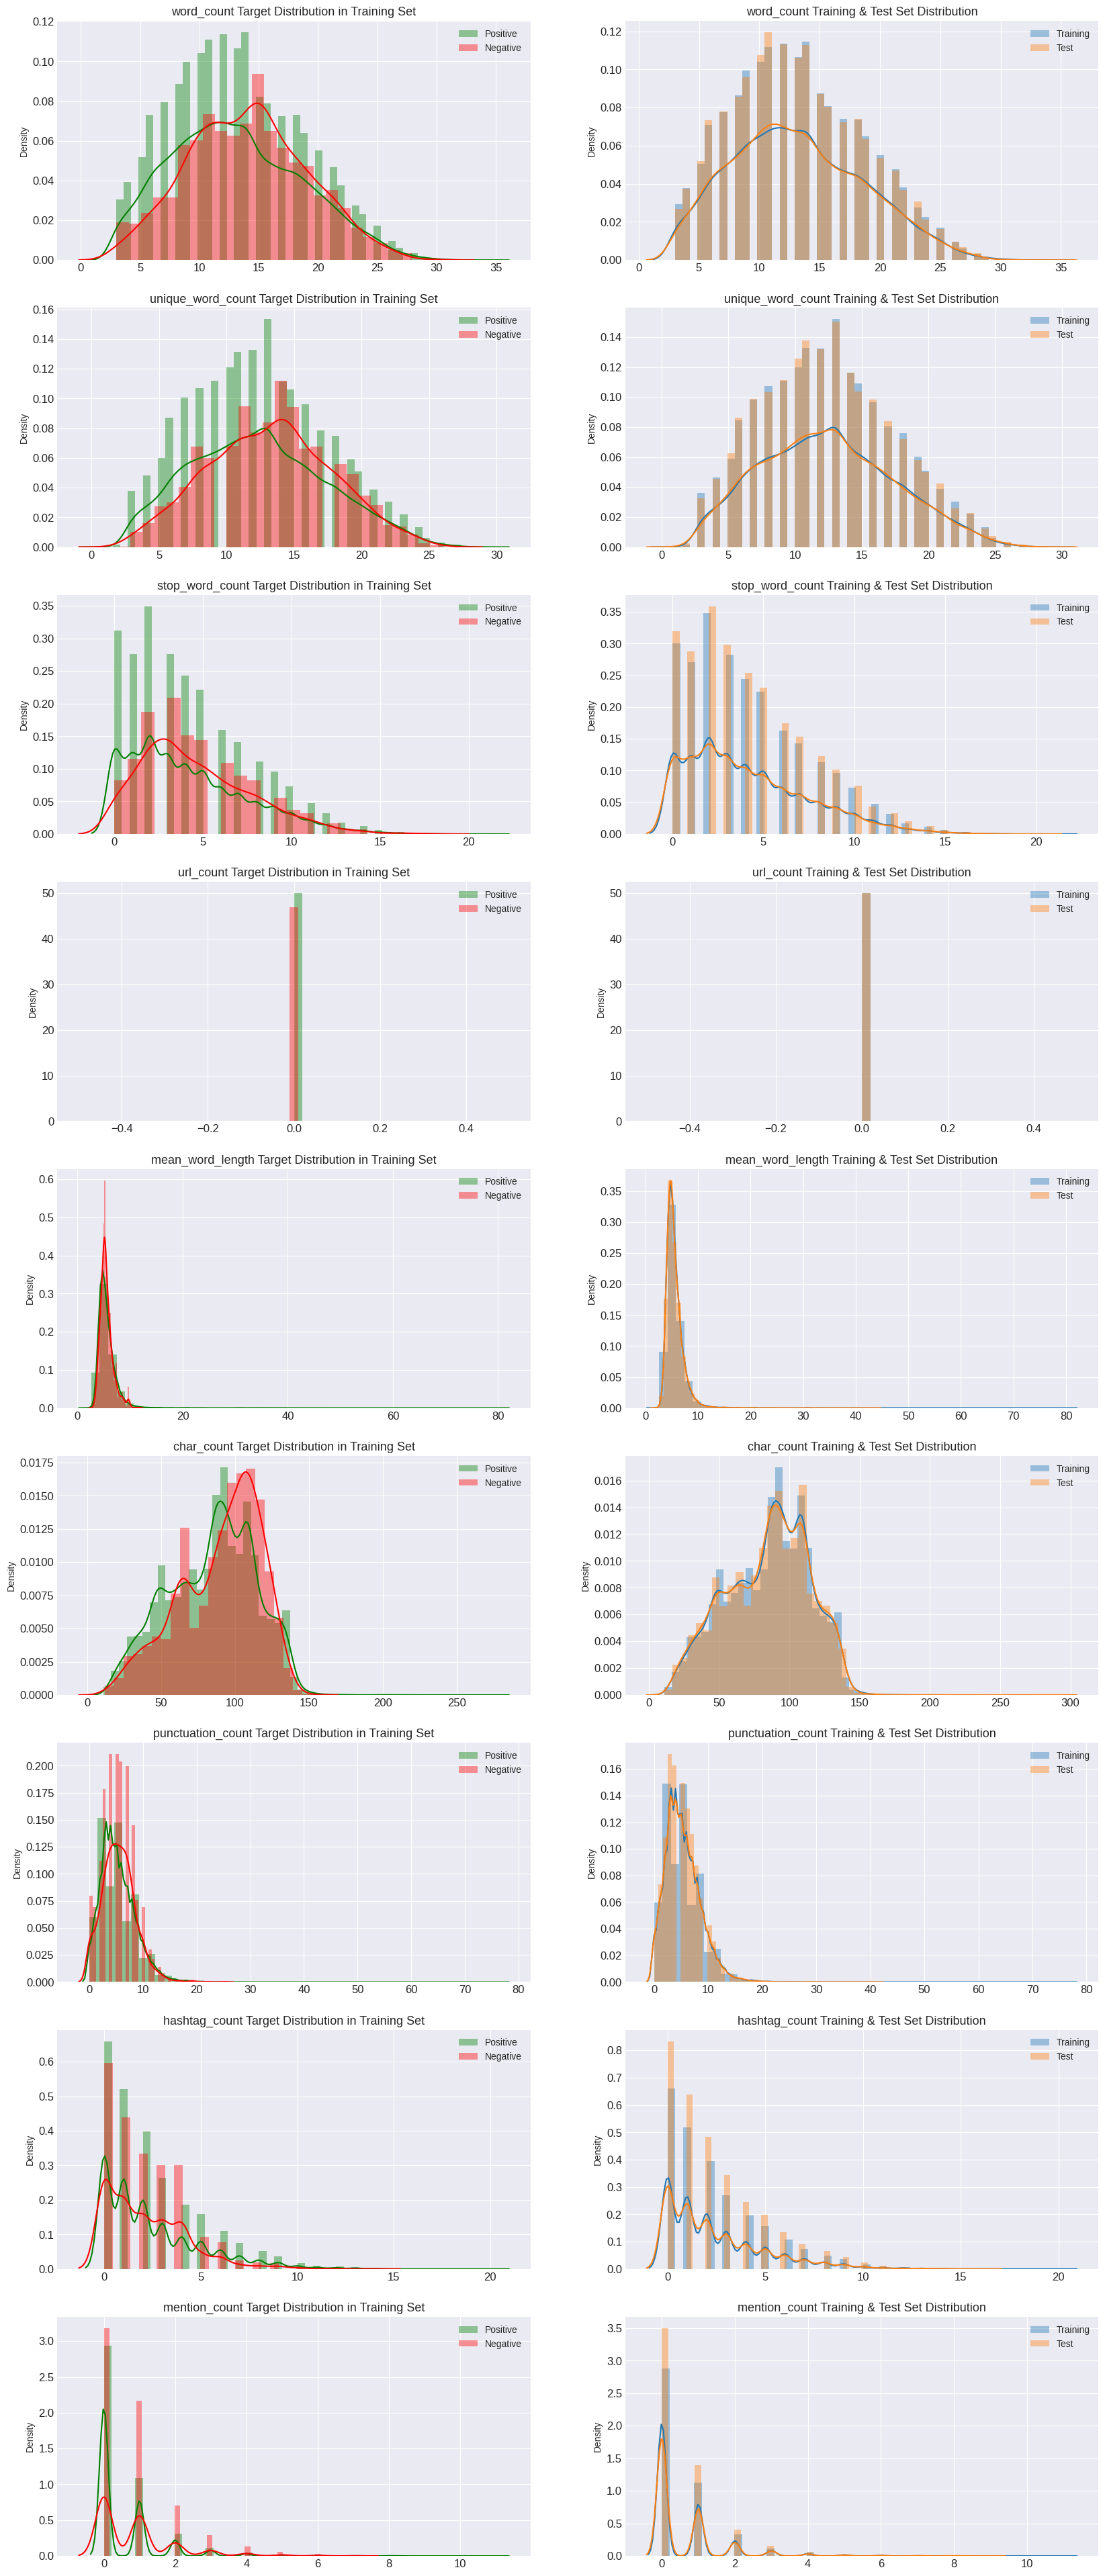

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
        'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

TWEETS = train['label'] == 1

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (20, 50), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~TWEETS][feature], label = 'Positive', ax = axes[i][0], color = 'green')
    sns.distplot(train.loc[TWEETS][feature], label = 'Negative', ax = axes[i][0], color = 'red')

    sns.distplot(train[feature], label = 'Training', ax = axes[i][1])
    sns.distplot(test[feature], label = 'Test', ax = axes[i][1])
  
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis = 'x', labelsize = 12)
        axes[i][j].tick_params(axis = 'y', labelsize = 12)
        axes[i][j].legend()
  
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize = 13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize = 13)

plt.show()

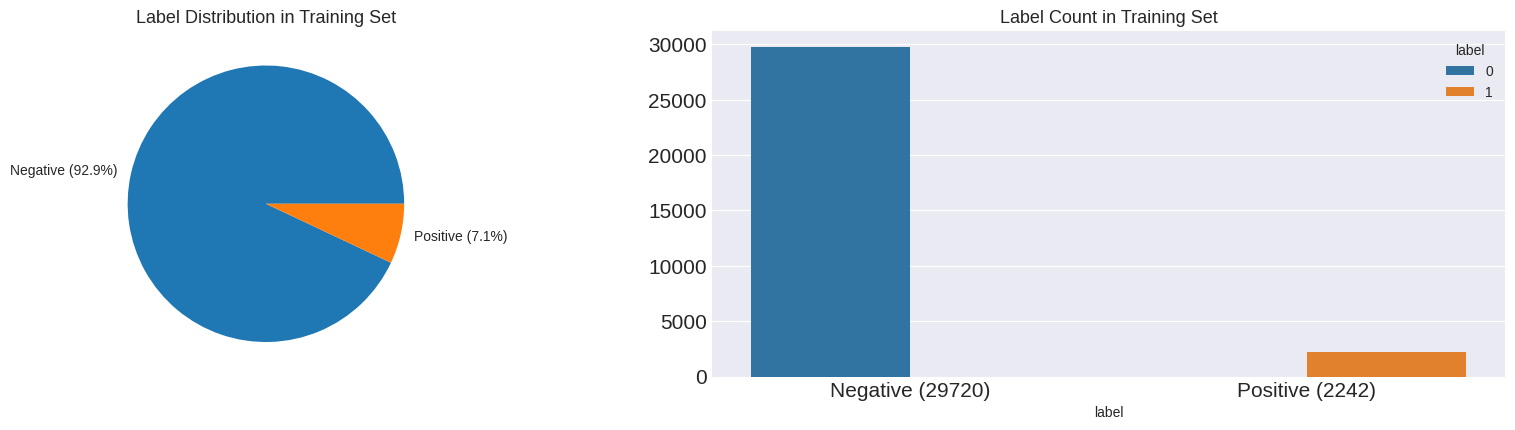

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (17, 4), dpi = 100)
plt.tight_layout()

train.groupby('label').count()['id'].plot(kind = 'pie', ax = axes[0], labels = ['Negative (92.9%)', 'Positive (7.1%)'])
sns.countplot(x = train['label'], hue = train['label'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Negative (29720)', 'Positive (2242)'])
axes[0].tick_params(axis = 'x', labelsize = 15)
axes[0].tick_params(axis = 'y', labelsize = 15)
axes[1].tick_params(axis = 'x', labelsize = 15)
axes[1].tick_params(axis = 'y', labelsize = 15)

axes[0].set_title('Label Distribution in Training Set', fontsize = 13)
axes[1].set_title('Label Count in Training Set', fontsize = 13)

plt.show()

Data Preprocessing and Cleaning

In [ ]:
def remove_stopwords(string):
    word_list = [word.lower() for word in string.split()]
    stopwords_list = list(stopwords.words("english"))
    for word in word_list:
        if word in stopwords_list:
            word_list.remove(word)
    return ' '.join(word_list)

In [ ]:
train['tweet_length'] = train['tweet'].apply(len)
train['tweet'] = train['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'https\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'http\s+|www.\s+',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
train['tweet'] = train['tweet'].str.lower()

train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
train['tweet'] = train['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
train['tweet'] = train['tweet'].apply(lambda x: remove_stopwords(x))

test['tweet'] = test['tweet'].map(lambda x: re.sub('\\n',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\W',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'\s+',' ',str(x)))
test['tweet'] = test['tweet'].str.lower()

test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’", "\'", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"dont", "do not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\’t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"n\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'re", " are", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'s", " is", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\’d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\d", " would", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ll", " will", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'t", " not", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'ve", " have", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'m", " am", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\n", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\r", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\'", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r"\"", "", str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
test['tweet'] = test['tweet'].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
test['tweet'] = test['tweet'].apply(lambda x: remove_stopwords(x))

In [ ]:
def clean_text(text):
    '''make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('user ', '', text)
    text = re.sub('amp ', '', text)
    text = re.sub('like ', '', text)
    text = re.sub('new ', '', text)
    text = re.sub('people ', '', text)
    text = re.sub('bihday', 'birthday', text)
    text = re.sub('allahsoil', 'allah soil', text)
    return text

In [ ]:
train['tweet'] = train['tweet'].apply(lambda x: clean_text(x))
test['tweet'] = test['tweet'].apply(lambda x: clean_text(x))

In [ ]:
train_data = train.copy()

label = {0: 'A', 1: 'B'}
train['label'] = train['label'].map(label)
train = train.drop('id', axis = 1)

train = pd.get_dummies(train, columns = ['label'])
train.head()

,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,tweet_length,label_A,label_B
0,father dysfunctional is selfish drags kids his...,18,16,10,0,4.555556,102,3,1,1,102,1,0
1,thanks lyft credit use cause don offer wheelch...,19,18,6,0,5.315789,122,8,3,2,122,1,0
2,birthday majesty,3,3,1,0,5.666667,21,0,0,0,21,1,0
3,model love take all time urð ð ð ð ð ð ð ð,14,13,5,0,4.928571,86,4,1,0,86,1,0
4,factsguide society motivation,4,4,0,0,8.000000,39,2,1,0,39,1,0


In [ ]:
categories = ['label_A', 'label_B']

train_dict = {}

for column in categories:
    a = train.loc[train[column] == 1, 'tweet'].tolist()
    train_dict[column] = ' '.join(a)

In [ ]:
# We can either keep it in dictionary format or put it into a pandas dataframe

data_df = pd.DataFrame(train_dict.items())
data_df.columns = ['index', 'tweet']
data_df = data_df.set_index('index')
data_df = data_df.sort_index()
data_df.head()

,tweet
index,
label_A,father dysfunctional is selfish drags kids his...
label_B,cnn calls michigan middle school build wall ch...


In [ ]:
data_df = pd.DataFrame(data_df['tweet'].apply(lambda x: clean_text(x)))
data_clean = data_df.copy()
data_df.head()

,tweet
index,
label_A,father dysfunctional is selfish drags kids his...
label_B,cnn calls michigan middle school build wall ch...


In [ ]:
cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(data_df['tweet'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm = data_dtm.transpose()
data_dtm.head()

index,label_A,label_B
aa,2,0
aaa,3,0
aaaaa,1,0
aaaaaand,1,0
aaaaah,1,0


In [ ]:
# Find the top 30 words on each category

top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending = False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'label_A': [('love', 2722),
  ('day', 2321),
  ('happy', 1674),
  ('life', 1123),
  ('time', 1115),
  ('today', 1065),
  ('thankful', 946),
  ('positive', 928),
  ('birthday', 846),
  ('good', 833),
  ('smile', 711),
  ('father', 631),
  ('want', 625),
  ('healthy', 602),
  ('weekend', 597),
  ('work', 595),
  ('fun', 587),
  ('summer', 576),
  ('make', 530),
  ('friday', 523),
  ('family', 519),
  ('got', 514),
  ('beautiful', 509),
  ('best', 508),
  ('bull', 503),
  ('friends', 500),
  ('way', 492),
  ('great', 486),
  ('need', 486),
  ('days', 486)],
 'label_B': [('trump', 207),
  ('libtard', 149),
  ('white', 139),
  ('black', 134),
  ('racist', 107),
  ('politics', 96),
  ('soil', 92),
  ('allah', 92),
  ('liberal', 82),
  ('women', 78),
  ('sjw', 74),
  ('obama', 72),
  ('hate', 71),
  ('racism', 65),
  ('retweet', 61),
  ('feel', 59),
  ('listen', 57),
  ('america', 54),
  ('stomping', 48),
  ('right', 47),
  ('men', 46),
  ('race', 46),
  ('woman', 43),
  ('comments', 39),
  

In [ ]:
# Print the top 15 words said by each category

for category, top_words in top_dict.items():
    print(category + ":")
    print(', '.join([word for word, count in top_words[0:14]]))
    print('-----------------------------------------------------------------------------------------------------------------------')

label_A:
love, day, happy, life, time, today, thankful, positive, birthday, good, smile, father, want, healthy
-----------------------------------------------------------------------------------------------------------------------
label_B:
trump, libtard, white, black, racist, politics, soil, allah, liberal, women, sjw, obama, hate, racism
-----------------------------------------------------------------------------------------------------------------------


#making word clouds


In [ ]:
# Let's first pull out the top words for each category

words = []
for category in data_dtm.columns:
    top = [word for (word, count) in top_dict[category]]
    for t in top:
        words.append(t)
        
words

# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('love', 1),
 ('day', 1),
 ('happy', 1),
 ('life', 1),
 ('time', 1),
 ('today', 1),
 ('thankful', 1),
 ('positive', 1),
 ('birthday', 1),
 ('good', 1),
 ('smile', 1),
 ('father', 1),
 ('want', 1),
 ('healthy', 1),
 ('weekend', 1),
 ('work', 1),
 ('fun', 1),
 ('summer', 1),
 ('make', 1),
 ('friday', 1),
 ('family', 1),
 ('got', 1),
 ('beautiful', 1),
 ('best', 1),
 ('bull', 1),
 ('friends', 1),
 ('way', 1),
 ('great', 1),
 ('need', 1),
 ('days', 1),
 ('trump', 1),
 ('libtard', 1),
 ('white', 1),
 ('black', 1),
 ('racist', 1),
 ('politics', 1),
 ('soil', 1),
 ('allah', 1),
 ('liberal', 1),
 ('women', 1),
 ('sjw', 1),
 ('obama', 1),
 ('hate', 1),
 ('racism', 1),
 ('retweet', 1),
 ('feel', 1),
 ('listen', 1),
 ('america', 1),
 ('stomping', 1),
 ('right', 1),
 ('men', 1),
 ('race', 1),
 ('woman', 1),
 ('comments', 1),
 ('miamiâ', 1),
 ('stop', 1),
 ('video', 1),
 ('man', 1),
 ('sex', 1),
 ('blm', 1)]

In [ ]:
data_dtm

index,label_A,label_B
aa,2,0
aaa,3,0
aaaaa,1,0
aaaaaand,1,0
aaaaah,1,0
...,...,...
ð¾ð½ðµð,1,0
ð¾ñ,2,0
ó¾,272,0
øª,1,0


In [ ]:
# Find the bottom 200 words in each category

bottom_dict = {}
for c in data_dtm.columns:
    bottom = data_dtm[c].sort_values(ascending = True).head(200)
    bottom_dict[c]= list(zip(bottom.index, bottom.values))

# Let's first pull out the bottom words for each category

bottom_words = []
for category in data_dtm.columns:
    bottom = [word for (word, count) in bottom_dict[category]]
    for b in bottom:
        bottom_words.append(b)

Counter(bottom_words).most_common()

[('blazing', 1),
 ('eugenie', 1),
 ('imo', 1),
 ('nobdy', 1),
 ('hebrews', 1),
 ('nobelprize', 1),
 ('chriâ', 1),
 ('wso', 1),
 ('stillwithher', 1),
 ('christmassy', 1),
 ('christmaseve', 1),
 ('christmasadve', 1),
 ('jerusalem', 1),
 ('noborders', 1),
 ('ksa', 1),
 ('heed', 1),
 ('tefugeeswelcome', 1),
 ('noafd', 1),
 ('bikinis', 1),
 ('eugenics', 1),
 ('ethnocentrism', 1),
 ('chumps', 1),
 ('chump', 1),
 ('degrading', 1),
 ('billionaire', 1),
 ('impeachtrump', 1),
 ('kumbaya', 1),
 ('heededâ', 1),
 ('billing', 1),
 ('etre', 1),
 ('impacts', 1),
 ('bwahahahahaha', 1),
 ('bilal', 1),
 ('jerodtwin', 1),
 ('wtfâ', 1),
 ('asianmen', 1),
 ('jeremyjoseph', 1),
 ('impeachtrumpâ', 1),
 ('scale', 1),
 ('christiaâ', 1),
 ('parentage', 1),
 ('realitycheck', 1),
 ('fliers', 1),
 ('wahhhh', 1),
 ('kot', 1),
 ('marxism', 1),
 ('marxist', 1),
 ('evan', 1),
 ('assistants', 1),
 ('realiâ', 1),
 ('immanuelâ', 1),
 ('asslicker', 1),
 ('deltaairlines', 1),
 ('associated', 1),
 ('bigotâ', 1),
 ('stigmatiz

In [ ]:
# Let's make some word clouds!

stop_words = text.ENGLISH_STOP_WORDS

wc = WordCloud(stopwords = stop_words, background_color = "white", colormap = "Dark2", max_font_size = 150, random_state = 42)

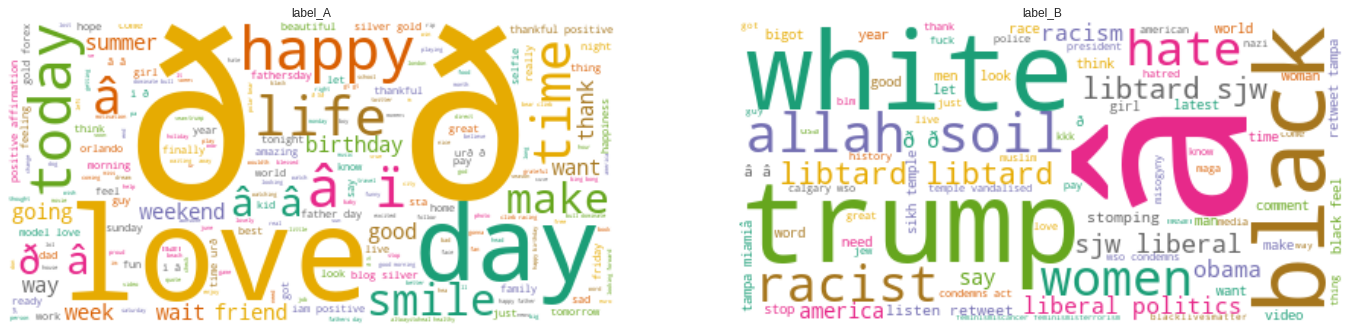

In [ ]:
# Create subplots for each category

for index, description in enumerate(data_dtm.columns):
    wc.generate(data_clean.tweet[description])
    
    plt.subplot(1, 2, index + 1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(categories[index])
    
plt.show()

In [ ]:
# Find the number of unique words that each category has

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for category in data_dtm.columns:
    uniques = data_dtm[category].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(categories, unique_list)), columns = ['category', 'unique_words'])
data_unique_sort = data_words.sort_values(by = 'unique_words')
data_unique_sort

,category,unique_words
1,label_B,5725
0,label_A,37701


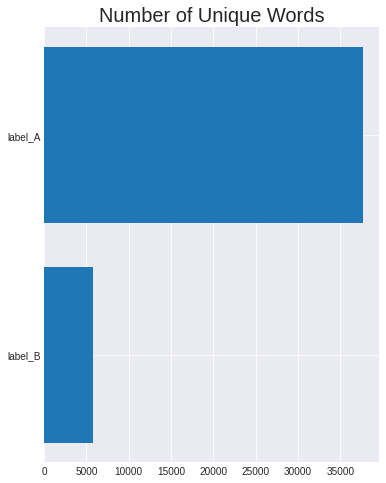

In [ ]:
y_pos = np.arange(len(data_words))

plt.figure(figsize = (6, 8))
plt.barh(y_pos, data_unique_sort.unique_words, align = 'center')
plt.yticks(y_pos, data_unique_sort.category)
plt.title('Number of Unique Words', fontsize = 20)
plt.show()

# Model Building

In [ ]:
Train, Test = train_test_split(train_data.drop('id', axis = 1), test_size = 0.25, random_state = 22) # Splits Dataset into Training and Testing set
print("Train Data size:", len(Train))
print("Test Data size", len(Test))

Train Data size: 23971
Test Data size 7991


In [ ]:
Train.head()

,label,tweet,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,tweet_length
25619,0,share happiness friday ð friday makeitagoodone...,10,10,2,0,8.000000,93,11,4,0,93
2634,0,watch facebook page competition be posted afte...,14,14,4,0,5.785714,96,4,2,0,96
1931,0,find home away home kappa kappa gamma sign for...,21,19,5,0,4.523810,118,7,1,1,118
21536,0,being censored youtube war vegans truth,9,9,3,0,5.333333,59,4,1,0,59
8707,0,quotestags quote nofilter quotestagsapp,4,4,0,0,10.000000,47,4,3,0,47


# Keras Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Train.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 33586


In [ ]:
MAX_LENGTH = 30

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(Train.tweet), maxlen = MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(Test.tweet),
                       maxlen = MAX_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (23971, 30)
Testing X Shape: (7991, 30)


In [ ]:
# Get all the train labels

labels = Train.tweet.unique().tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Train.label.to_list())

y_train = encoder.transform(Train.label.to_list())
y_test = encoder.transform(Test.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (23971, 1)
y_test shape: (7991, 1)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-23 22:27:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-23 22:27:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-23 22:27:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!ls
!pwd

drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [ ]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
BATCH_SIZE = 16
EPOCHS = 15
MODEL_PATH = '/content/best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False)

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape = (MAX_LENGTH,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LR = 1e-3

model.compile(optimizer = Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [ ]:
history = model.fit(X_train, y_train, batch_size = 320, epochs = 15, validation_data = (X_test, y_test), callbacks = [ReduceLROnPlateau])

Epoch 1/15
75/75 [==============================] - 21s 275ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.3533 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/15
75/75 [==============================] - 21s 280ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.4281 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 3/15
75/75 [==============================] - 20s 266ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.4275 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 4/15
75/75 [==============================] - 23s 309ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.4492 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 5/15
75/75 [==============================] - 22s 292ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.4420 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 6/15
75/75 [==============================] - 23s 302ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 0.4404 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 7/15
75/75 [==============================] - 23s 303ms/st

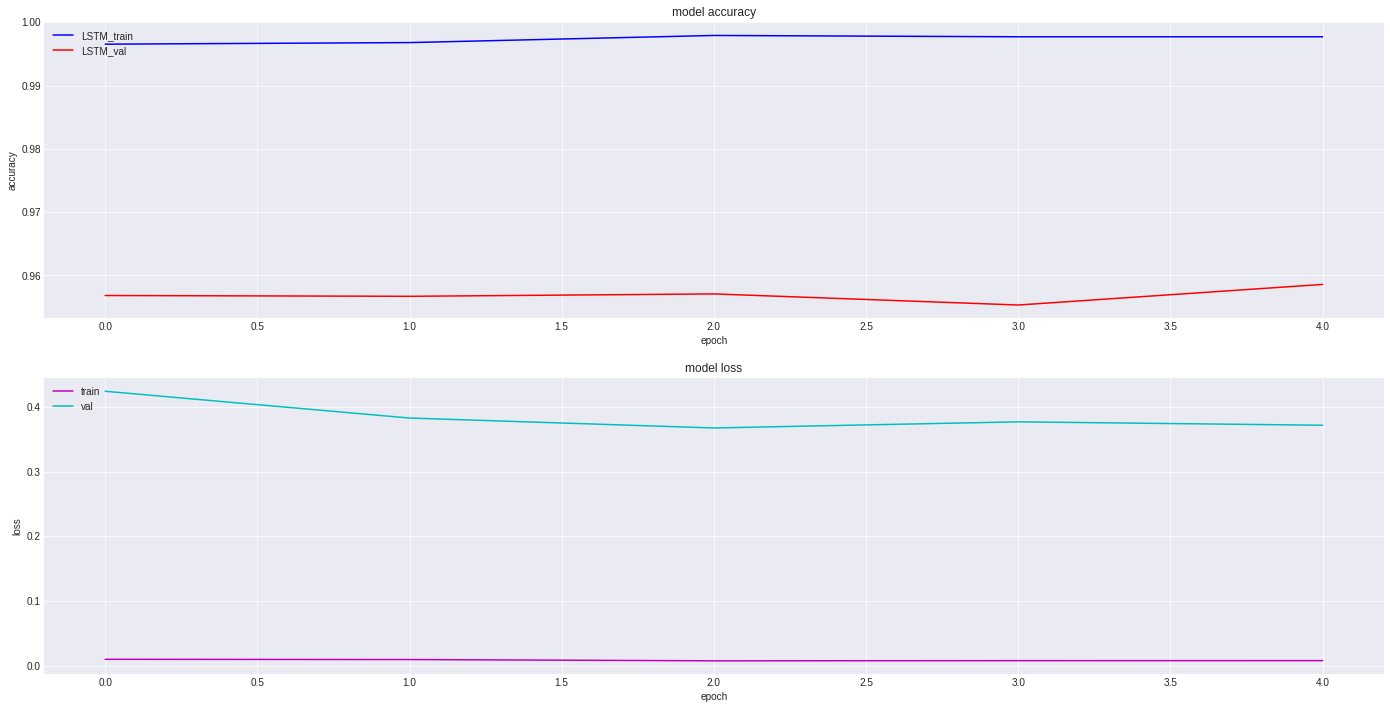

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c = 'b')
at.plot(history.history['val_accuracy'], c ='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc ='upper left')

al.plot(history.history['loss'], c ='m')
al.plot(history.history['val_loss'], c ='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = model.predict(X_test, verbose = 1, batch_size = 10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 1s/step


In [ ]:
#classification matrix
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 13)
    plt.yticks(tick_marks, classes, fontsize = 13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 17)
    plt.xlabel('Predicted label', fontsize = 17)

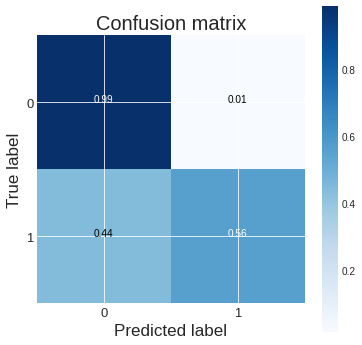

In [ ]:
cnf_matrix = confusion_matrix(Test.label.to_list(), y_pred_1d)
plt.figure(figsize = (6,6))
plot_confusion_matrix(cnf_matrix, classes = Test.label.unique(), title = "Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(Test.label), y_pred_1d))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      7447
           1       0.77      0.56      0.65       544

    accuracy                           0.96      7991
   macro avg       0.87      0.77      0.81      7991
weighted avg       0.95      0.96      0.96      7991



In [ ]:
results = pd.DataFrame()

Y_test = pad_sequences(tokenizer.texts_to_sequences(test.tweet), maxlen = MAX_LENGTH)


final_scores = model.predict(Y_test, verbose = 1, batch_size = 10000)
y_pred_1d = [decode_sentiment(score) for score in final_scores]

results['id'] = test['id'].tolist()
results['label'] = y_pred_1d
results.to_csv('tweets_v2.csv', index = False)
results.head()

2/2 [==============================] - 3s 1s/step


,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
